In [1]:
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import Image 
from scipy.ndimage import uniform_filter
import numpy as np
from pathlib import Path
import vcf
import re
import sys
#from tqdm import tqdm
import glob
import shutil


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"

# TWISST: Phylogenetic identification of introgressed genomic regions

In [3]:
Path("{}/results/twisst/play".format(proj_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/results/twisst/play".format(proj_dir))

## Get VCF file of appropriate snps:

In [ ]:
#NC_067199.1:28_467_137-28_495_140

In [62]:
%%bash

conda run -n scan_phylo --cwd . --live-stream
    vcftools \
        --vcf ../../post_phase_filtering/chrs_unrelated.vcf \
        --remove-indv guineensis_saotome_ERR119612 \
        --remove-indv intercalatum_drcongo_ERR119613 \
        --remove-indv matthei_zambia_ERR103051 \
        --singletons



VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../../post_phase_filtering/chrs_unrelated.vcf
	--singletons
	--remove-indv guineensis_saotome_ERR119612
	--remove-indv intercalatum_drcongo_ERR119613
	--remove-indv matthei_zambia_ERR103051

Excluding individuals in 'exclude' list
After filtering, kept 163 out of 166 Individuals
Outputting Singleton Locations
After filtering, kept 35817757 out of a possible 35817757 Sites
Run Time = 752.00 seconds


In [ ]:
%%bash

grep -v margrebowiei_zambia_ERR310940 out.singletons | sed 1d | cut -f1,2 >singletons.pos

In [63]:
%%bash

vcftools \
    --vcf ../../post_phase_filtering/chrs_unrelated.vcf \
    --remove-indv guineensis_saotome_ERR119612 \
    --remove-indv intercalatum_drcongo_ERR119613 \
    --remove-indv matthei_zambia_ERR103051 \
    --exclude-positions singletons.pos \
    --recode \
    --recode-INFO-all \
    --out twisst


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../../post_phase_filtering/chrs_unrelated.vcf
	--exclude-positions singletons.pos
	--recode-INFO-all
	--out twisst
	--recode
	--remove-indv guineensis_saotome_ERR119612
	--remove-indv intercalatum_drcongo_ERR119613
	--remove-indv matthei_zambia_ERR103051

Excluding individuals in 'exclude' list
After filtering, kept 163 out of 166 Individuals
Outputting VCF file...
After filtering, kept 29863391 out of a possible 35817757 Sites
Run Time = 2136.00 seconds


In [64]:
%%bash 

conda run -n bcftools --cwd . --live-stream bgzip -c twisst.recode.vcf > twisst.vcf.gz
conda run -n bcftools --cwd . --live-stream tabix -p vcf twisst.vcf.gz

In [65]:
%%bash

conda run -n bcftools --cwd . --live-stream bcftools view twisst.vcf.gz -Ob >twisst.bcf
conda run -n bcftools --cwd . --live-stream bcftools index --threads 12 twisst.bcf

In [66]:
%%bash

conda run -n scan_phylo --cwd . --live-stream bedtools makewindows -g ../../../data/GCF_000699445.3_UoM_Shae.V3_genomic.fna.fai -w 10000 -s 5000 >windows.bed

In [67]:
%%bash

#get counts
conda run -n scan_phylo --cwd . --live-stream bedtools intersect -c -a windows.bed -b twisst.vcf.gz >window.counts

In [68]:
%%bash

#remove those with less than X
awk '{if ($4>250) print $0}' window.counts >inf.bed

In [ ]:
%%bash

mkdir logs
mkdir gene_vcfs

process_line() {
    read -r CHROM START STOP COUNT rest <<< "$1"
    
    REGION="${CHROM}:${START}-${STOP}"
    OUT_VCF="gene_vcfs/${CHROM}-${START}-${STOP}.vcf"

    conda run -n bcftools --cwd . --live-stream bcftools view -r ${REGION} -O v twisst.bcf >${OUT_VCF}
}
export -f process_line

cat inf.bed | parallel -j192 process_line

In [ ]:
%%bash 

conda run -n diploid_to_haploid_vcf --cwd . --live-stream \
    python ~/sch_hae_scan/code/diploid_to_haploid_vcf.py \
        "/master/nplatt/sch_hae_scan/results/twisst/play/gene_vcfs/*vcf" \
        gene_tree_coords.csv

In [ ]:
%%bash

mkdir gene_phylips

cp gene_vcfs/*phylip gene_phylips/

rename .vcf.phylip .phy gene_phylips/*.vcf.phylip

In [ ]:
%%bash
mkdir gene_trees
mkdir raxml_logs

In [ ]:
conda run -n snakemake --cwd . --live-stream \
    snakemake \
        --printshellcmds \
        --cluster 'qsub -V -cwd -j y -S /bin/bash -pe smp {threads} -q all.q ' \
        --jobs 175 \
        --latency-wait 60 \
        --keep-going \
        --snake ../../../code/build_gene_trees.snk.py \
        --use-conda \
        --jobname snk.TWST.{name}.jid{jobid}

In [ ]:
%%bash

cat gene_trees/*raxml.bestTree >gene_trees.nwk

#get coords
ls gene_trees/*raxml.bestTree | sed 's/gene_trees\///' | sed 's/.raxml.bestTree//' | sed 's/-/,/g' >gene_tree_coords.csv

In [ ]:
%%bash
nw_ed gene_trees.nwk 'i & b<=10' o > gene_trees_BS10.nwk

## Run Twisst

In [4]:
!conda run -n bcftools --cwd . --live-stream bcftools query -l twisst.vcf >samples.list

In [5]:
pca_df=pd.read_csv("{}/results/pca/pca_df.csv".format(proj_dir), sep=",")

groups  = []
hap_ids = []
with open('samples.list') as ifile:
    for sample in ifile:
        try:
            group=pca_df.loc[pca_df["sample_name"] == sample.rstrip(), "kmeans_label"].values[0]
        except:
            group="outgroup"
            
        groups.append(group)
        groups.append(group)
        
        h1 = "{}_h1".format(sample.rstrip())
        h2 = "{}_h2".format(sample.rstrip())
        
        hap_ids.append(h1)
        hap_ids.append(h2)
        
tmp_df = pd.DataFrame()
tmp_df["hap_ids"] = hap_ids
tmp_df["groups"] = groups
tmp_df.to_csv("groups.list", header=False, index=False, sep="\t")

In [ ]:
 %%bash 
    
python ~/sch_hae_scan/bin/twisst/twisst.py \
    --treeFile gene_trees.nwk \
    --outgroup s_margrebowiei \
    --groupsFile groups.list \
    -g sh_nw \
    -g sb \
    -g sh_se \
    -g s_margrebowiei \
    --outputTopos twisst_topologies \
    -w twisst_weights

## Plot Twisst results

In [7]:
!cat twisst_topologies

(s_margrebowiei,((sh_nw,sb),sh_se));
(s_margrebowiei,((sh_nw,sh_se),sb));
(s_margrebowiei,(sh_nw,(sb,sh_se)));


In [74]:
#read in topology weights file and convert to percentages
w_df=pd.read_csv("twisst_weights", comment='#', sep="\t")
p_df = w_df.div(w_df.sum(axis=1), axis=0)

In [77]:
c_df=pd.read_csv("sorted_gene_tree_coords.csv", sep=",", header=None)
c_df.columns=["id", "chrom", "start", "stop"]
c_df

,id,chrom,start,stop
0,NC_067195.1-10000000-10010000,NC_067195.1,10000009,10009995
1,NC_067195.1-1000000-1010000,NC_067195.1,1000001,1009988
2,NC_067195.1-10000-20000,NC_067195.1,14416,17189
3,NC_067195.1-10010000-10020000,NC_067195.1,10010001,10019996
4,NC_067195.1-10020000-10030000,NC_067195.1,10020010,10029996
...,...,...,...,...
37194,NC_067202.1-9950000-9960000,NC_067202.1,9950010,9958849
37195,NC_067202.1-9960000-9970000,NC_067202.1,9961913,9968894
37196,NC_067202.1-9970000-9980000,NC_067202.1,9970963,9979992
37197,NC_067202.1-9980000-9990000,NC_067202.1,9980008,9990000


In [78]:
p_df

,topo1,topo2,topo3
0,0.000000,0.993902,0.006098
1,0.706852,0.061286,0.231862
2,0.532234,0.190201,0.277566
3,0.000000,0.993902,0.006098
4,0.000000,0.993902,0.006098
...,...,...,...
37194,0.030488,0.963415,0.006098
37195,0.606168,0.167150,0.226681
37196,0.030488,0.963415,0.006098
37197,0.024390,0.969512,0.006098


In [79]:
df = pd.concat([p_df, c_df], axis=1)
df

,topo1,topo2,topo3,id,chrom,start,stop
0,0.000000,0.993902,0.006098,NC_067195.1-10000000-10010000,NC_067195.1,10000009,10009995
1,0.706852,0.061286,0.231862,NC_067195.1-1000000-1010000,NC_067195.1,1000001,1009988
2,0.532234,0.190201,0.277566,NC_067195.1-10000-20000,NC_067195.1,14416,17189
3,0.000000,0.993902,0.006098,NC_067195.1-10010000-10020000,NC_067195.1,10010001,10019996
4,0.000000,0.993902,0.006098,NC_067195.1-10020000-10030000,NC_067195.1,10020010,10029996
...,...,...,...,...,...,...,...
37194,0.030488,0.963415,0.006098,NC_067202.1-9950000-9960000,NC_067202.1,9950010,9958849
37195,0.606168,0.167150,0.226681,NC_067202.1-9960000-9970000,NC_067202.1,9961913,9968894
37196,0.030488,0.963415,0.006098,NC_067202.1-9970000-9980000,NC_067202.1,9970963,9979992
37197,0.024390,0.969512,0.006098,NC_067202.1-9980000-9990000,NC_067202.1,9980008,9990000


In [ ]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x_start=[]
x_end=[]
c=[]

for index, row in df.iterrows():
    chrom = row["chrom"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x_start.append(row["start"] + offset)
    x_end.append(row["stop"] + offset)

    c.append(color)
    
df["x_start"] = x_start
df["x_end"] = x_end
df["color"] = c

df.to_csv("twisst_results.csv", header=True, sep=",", index=False)


In [17]:
df = pd.read_csv("twisst_results.csv", sep=",")
df

,topo1,topo2,topo3,chrom,start,stop,x_start,x_end,color
0,0.332619,0.321227,0.346154,NC_067196.1,140000,150000,140000,150000,#078d70
1,0.440908,0.245261,0.313831,NC_067196.1,150000,160000,150000,160000,#078d70
2,0.173354,0.347872,0.478774,NC_067196.1,170000,180000,170000,180000,#078d70
3,0.230086,0.344603,0.425311,NC_067196.1,190000,200000,190000,200000,#078d70
4,0.044135,0.345819,0.610046,NC_067196.1,200000,210000,200000,210000,#078d70
...,...,...,...,...,...,...,...,...,...
37194,0.034983,0.944381,0.020635,NC_067195.1,89100000,89110000,409513657,409523657,#7bade3
37195,0.286237,0.567856,0.145907,NC_067195.1,89110000,89120000,409523657,409533657,#7bade3
37196,0.035714,0.963415,0.000871,NC_067195.1,89120000,89130000,409533657,409543657,#7bade3
37197,0.044543,0.737650,0.217807,NC_067195.1,89130000,89140000,409543657,409553657,#7bade3


In [ ]:
fig, ax = plt.subplots()

# Plotting topo1
ax.bar(df['x_start'], df['topo1'], width=df['x_end'] - df['x_start'], label='topo1')

# Plotting topo2 on top of topo1
ax.bar(df['x_start'], df['topo2'], width=df['x_end'] - df['x_start'], bottom=df['topo1'], label='topo2')

# Plotting topo3 on top of (topo1 + topo2)
ax.bar(df['x_start'], df['topo3'], width=df['x_end'] - df['x_start'], bottom=df['topo1'] + df['topo2'], label='topo3')

ax.set_xlabel('Position')
ax.set_ylabel('Value')
ax.set_title('Stacked Barplot')
#ax.legend()

plt.show()


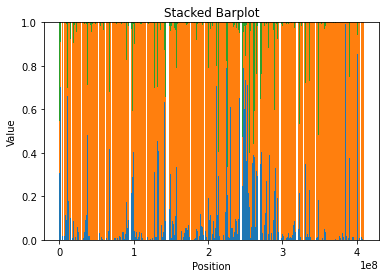

In [19]:
# Plotting
fig, ax = plt.subplots()

# Plotting topo1
ax.bar(df['x_start'], df['topo1'], width=df['x_end'] - df['x_start'], label='topo1')

# Plotting topo2 on top of topo1
ax.bar(df['x_start'], df['topo2'], width=df['x_end'] - df['x_start'], bottom=df['topo1'], label='topo2')

# Plotting topo3 on top of (topo1 + topo2)
ax.bar(df['x_start'], df['topo3'], width=df['x_end'] - df['x_start'], bottom=df['topo1'] + df['topo2'], label='topo3')

ax.set_xlabel('Position')
ax.set_ylabel('Value')
ax.set_title('Stacked Barplot')
#ax.legend()

plt.show()
